In [1]:
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from alexnet import AlexNet

In [2]:
# TODO: Load traffic signs data.
training_file = "train.p"
with open(training_file, mode='rb') as f:
    train_data = pickle.load(f)
print(train_data.keys())
for key in train_data.keys():
    print(train_data[key].shape)

dict_keys(['coords', 'sizes', 'labels', 'features'])
(39209, 2)
(39209, 2)
(39209,)
(39209, 32, 32, 3)


In [3]:
# Number of classes
sign_names = pd.read_csv('signnames.csv')
nb_classes = len(sign_names['ClassId'])

In [53]:
# TODO: Split data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(train_data['features'], train_data['labels'], test_size=0.33)

print("Training data size {}".format(len(X_train)))
print("Validation data size {}".format(len(X_valid)))
print(X_train.shape)
print(y_train.shape)

Training data size 26270
Validation data size 12939
(26270, 32, 32, 3)
(26270,)


In [6]:
# TODO: Define placeholders and resize operation.
model_graph = tf.Graph()
with model_graph.as_default():
    x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3))
    y = tf.placeholder(tf.int32, shape=(None,))
    resized = tf.image.resize_images(x, (227, 227))
    one_hot_y = tf.one_hot(y, nb_classes)

In [7]:
# TODO: pass placeholder as first argument to `AlexNet`.
with model_graph.as_default():
    fc7 = AlexNet(resized, feature_extract=True)

In [8]:
# NOTE: `tf.stop_gradient` prevents the gradient from flowing backwards
# past this point, keeping the weights before and up to `fc7` frozen.
# This also makes training faster, less work to do!
with model_graph.as_default():
    fc7 = tf.stop_gradient(fc7)

In [11]:
# TODO: Add the final layer for traffic sign classification.
with model_graph.as_default():
    fc8_shape = (fc7.get_shape().as_list()[-1], nb_classes)
    fc8_w = tf.get_variable('fc8_weights', fc8_shape, initializer=tf.contrib.layers.xavier_initializer())
    fc8_b = tf.get_variable('fc8_biases', nb_classes, initializer=tf.constant_initializer(0.0))
    predicted_logits = tf.nn.xw_plus_b(fc7, fc8_w, fc8_b)

In [54]:
# Hyper parameters
LEARN_RATE = 0.001
BATCH_SIZE = 128
EPOCHS = 10

In [14]:
# TODO: Define loss, training, accuracy operations.
# HINT: Look back at your traffic signs project solution, you may
# be able to reuse some the code.
with model_graph.as_default():
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=predicted_logits, labels=one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARN_RATE)
    training_operation = optimizer.minimize(loss_operation, var_list=[fc8_w, fc8_b])

    predictions = tf.argmax(predicted_logits, axis=1, output_type=tf.int32)
    correct_prediction = tf.equal(predictions, y)
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def evaluate(X_data, y_data):
        num_examples = len(X_data)
        total_loss = 0.0
        total_accuracy = 0.0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
            total_loss += loss * batch_x.shape[0]
            total_accuracy += accuracy * batch_x.shape[0]
        return (total_loss/num_examples, total_accuracy/num_examples)
            

In [51]:
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import style
from math import ceil
%matplotlib inline

style.use('ggplot')

class AccuracyPlot:
    def __init__(self):
        self.fig = plt.figure(figsize=(15, 10))
        self.axLoss = self.fig.add_subplot(211)
        self.axAccuracy = self.fig.add_subplot(212)
        self.train_loss_list = []
        self.train_accuracy_list = []
        self.valid_loss_list = []
        self.valid_accuracy_list = []

    def __plot(self, _ax, _x, _y, _label):
        _ax.set_xlabel('Epochs')
        _ax.set_xlim(0, ceil(EPOCHS*1.1))
        _ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        _ax.plot(_x, _y, label=_label)
        _ax.annotate("({}, {:.3f})".format(_x[-1], _y[-1]), xy=(_x[-1], _y[-1]))

    def __plot_loss(self):
        self.axLoss.clear()
        self.axLoss.set_ylabel('Loss')
        epochs = np.arange(1, len(self.train_loss_list)+1)
        self.__plot(self.axLoss, epochs, self.train_loss_list, 'Training Loss')
        self.__plot(self.axLoss, epochs, self.valid_loss_list, 'Validation Loss')
        self.axLoss.legend(loc='upper right')
    
    def __plot_accuracy(self):
        self.axAccuracy.clear()
        self.axAccuracy.set_ylim(0, 1.1)
        self.axAccuracy.set_ylabel('Accuracy')
        epochs = np.arange(1, len(self.train_accuracy_list)+1)
        self.__plot(self.axAccuracy, epochs, self.train_accuracy_list, 'Training Accuracy')
        self.__plot(self.axAccuracy, epochs, self.valid_accuracy_list, 'Validation Accuracy')
        self.axAccuracy.legend(loc='lower right')
        
    def plot(self, train_loss, valid_loss, train_accuracy, valid_accuracy):
        self.train_loss_list.append(train_loss)
        self.valid_loss_list.append(valid_loss)
        self.train_accuracy_list.append(train_accuracy)
        self.valid_accuracy_list.append(valid_accuracy)

        self.__plot_loss()
        self.__plot_accuracy()
         
        display.display(self.fig)
        display.clear_output(wait=True)

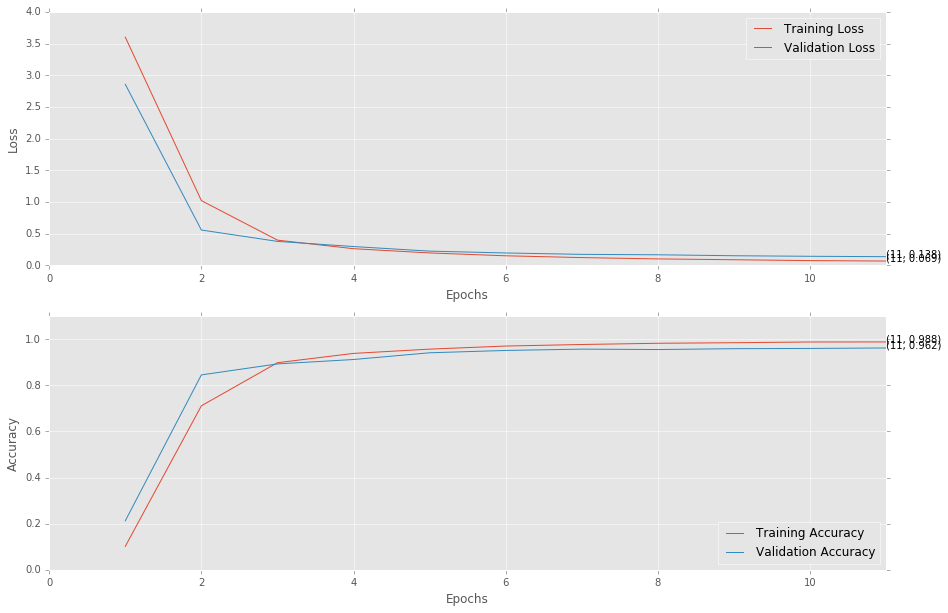

In [55]:
# TODO: Train and evaluate the feature extraction model.
from sklearn.utils import shuffle

with tf.Session(graph=model_graph) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    acc_plot = AccuracyPlot()
    print('Training model...')
    print()
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        train_loss = 0.0
        train_accuracy = 0.0
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]
            loss, accuracy, _ = sess.run([loss_operation, accuracy_operation, training_operation],
                                         feed_dict={x: batch_x, y: batch_y})
            train_loss += loss * batch_x.shape[0]
            train_accuracy += accuracy * batch_x.shape[0]
        train_loss /= num_examples
        train_accuracy /= num_examples
        valid_loss, valid_accuracy = evaluate(X_valid, y_valid)
        
        acc_plot.plot(train_loss, valid_loss, train_accuracy, valid_accuracy)